In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
def standarize_time_col(data):
    # find and return the name of the column containing 'time'
    time_column = None
    for col in data.columns:
        if 'time' in col.lower():
            time_column = col
            break
    if time_column:
        return time_column
    return None


def load_and_process_new_app(file_path):
    # load the new appliance data
    data = pd.read_csv(file_path, header=0, index_col=0)
    time_column_name = standarize_time_col(data)
    if time_column_name is None:
        print('No column containing \'time\'')
        return
    
    # standardize the naming
    data.rename(columns={time_column_name: 'time_app'}, inplace=True)
    data['time_app'] = pd.to_datetime(data['time_app']).dt.strftime('%m/%d/%Y %H:%M')
    data['time_app'] = pd.to_datetime(data['time_app'], format='%m/%d/%Y %H:%M')
    base_year = data['time_app'].iloc[0].year

    # convert W_min to kW
    data['W_min'] = data['W_min'] / 1000

    return data, base_year

def load_and_process_all(file_path, base_year):
    # load and process all appliance data
    data = pd.read_csv(file_path, header=0)
    time_column_name = standarize_time_col(data)
    if time_column_name is None:
        print('No column containing \'time\'')
        return
    
     # standardize the naming
    data.rename(columns={time_column_name: 'time_all'}, inplace=True)

    # correct the timestamp format
    data['time_all'] = data['time_all'].apply(lambda x : f"{base_year}" + x)
    data['time_all'] = data['time_all'].str.replace('24:00:00', '00:00:00')
    data['time_all'] = pd.to_datetime(data['time_all'], format='%Y %m/%d  %H:%M:%S')
    data.loc[data['time_all'].dt.hour == 0, 'time_all'] += pd.Timedelta(days=1)

    return data

def merge_data(data_all, data_app):
    # merge all appliance data with new appliance data
    final_data = pd.merge(data_all, data_app, how='inner', left_on='time_all', right_on='time_app')
    final_data.drop(columns=['time_app'], inplace=True)
    final_data.rename(columns={'time_all': 'time'}, inplace=True)
    final_data['W_min'].fillna(0, inplace=True)

    # compare the three columns later: 'Total_Consumption_Before_Merge', 'Total_Consumption', 'New_App_Electricity'
    electricity_cols = [col for col in final_data.columns if 'electricity' in col.lower()]
    final_data['Total_Consumption_Before_Merge'] = final_data[electricity_cols].sum(axis=1, numeric_only=True)

    final_data.rename(columns={'W_min': 'New_App_Electricity'}, inplace=True)
    electricity_cols.append('New_App_Electricity')
    final_data['Total_Consumption'] = final_data[electricity_cols].sum(axis=1, numeric_only=True)
    return final_data

def aggregate_app_data(data):
    # aggregate new appliance data to hourly basis
    data.set_index('time_app', inplace=True)
    hourly_data = data.resample('h').sum()
    hourly_data.reset_index(inplace=True)
    hourly_data['time_app'] = hourly_data['time_app'] + pd.Timedelta(hours=1)
    return hourly_data


In [3]:
# load data from the file path

file_path_app = "data/Assignment 2 - new.app4.csv"
file_path_all = "data/Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv"
data_app, base_year = load_and_process_new_app(file_path_app)
data_all = load_and_process_all(file_path_all, base_year)


In [4]:
# sum minute-by-minute data to hourly basis, and merge
data_app_hourly = aggregate_app_data(data_app)
final_data = merge_data(data_all, data_app_hourly)

In [5]:
final_data

,time,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),New_App_Electricity,Total_Consumption_Before_Merge,Total_Consumption
0,2013-06-07 12:00:00,1.559733,0.018441,0.0,0.0,0.454263,0.130764,0.585027,0.130764,0.047163,0.010160,0.350008,0.267735,0.282996,57.388943,3.818613,61.207557
1,2013-06-07 13:00:00,1.702835,0.019079,0.0,0.0,0.603876,0.169912,0.773789,0.169912,0.047163,0.010160,0.319024,0.276993,0.259063,27.227961,4.332728,31.560690
2,2013-06-07 14:00:00,1.859094,0.020153,0.0,0.0,0.752179,0.211629,0.963808,0.211629,0.047163,0.010160,0.294229,0.292590,0.234500,111.476298,4.876981,116.353279
3,2013-06-07 15:00:00,2.100629,0.021274,0.0,0.0,0.921579,0.253177,1.174756,0.253177,0.050307,0.010837,0.301026,0.308854,0.238204,109.021960,5.612548,114.634508
4,2013-06-07 16:00:00,2.362750,0.025163,0.0,0.0,1.026566,0.282008,1.308575,0.282008,0.050307,0.010837,0.342617,0.365320,0.268449,5.773963,6.299438,12.073401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456,2013-09-17 20:00:00,2.802815,0.035435,0.0,0.0,0.618448,0.190689,0.809137,0.190689,0.616948,0.132907,0.316662,0.514451,0.396065,0.081495,6.588813,6.670308
2457,2013-09-17 21:00:00,2.605447,0.034608,0.0,0.0,0.566775,0.173302,0.740077,0.173302,0.573501,0.123547,0.302602,0.502440,0.346635,0.081474,6.107630,6.189103
2458,2013-09-17 22:00:00,2.125480,0.029949,0.0,0.0,0.483947,0.147968,0.631915,0.147968,0.430126,0.092661,0.244765,0.434798,0.274572,0.082655,5.014199,5.096853
2459,2013-09-17 23:00:00,1.637118,0.026025,0.0,0.0,0.399007,0.121994,0.521001,0.121994,0.299785,0.064582,0.162484,0.377831,0.194791,0.081191,3.900589,3.981780


In [6]:
# check the start and end timestamps in each data file

start_timestamp = data_app_hourly['time_app'].min()
end_timestamp = data_app_hourly['time_app'].max()

print("Start Timestamp (Appliance):", start_timestamp)
print("End Timestamp (Appliance):", end_timestamp)

start_timestamp = data_all['time_all'].min()
end_timestamp = data_all['time_all'].max()

print("Start Timestamp (All):", start_timestamp)
print("End Timestamp (All):", end_timestamp)

start_timestamp = final_data['time'].min()
end_timestamp = final_data['time'].max()

print("Start Timestamp (Merged):", start_timestamp)
print("End Timestamp (Merged):", end_timestamp)

Start Timestamp (Appliance): 2013-06-07 12:00:00
End Timestamp (Appliance): 2013-09-18 00:00:00
Start Timestamp (All): 2013-01-01 01:00:00
End Timestamp (All): 2014-01-01 00:00:00
Start Timestamp (Merged): 2013-06-07 12:00:00
End Timestamp (Merged): 2013-09-18 00:00:00


In [7]:
# ensure 'time' is in datetime format for plotting
final_data['time'] = pd.to_datetime(final_data['time'])

# extract hour, weekday, and month
final_data['hour'] = final_data['time'].dt.hour
final_data['weekday'] = final_data['time'].dt.weekday
final_data['month'] = final_data['time'].dt.month

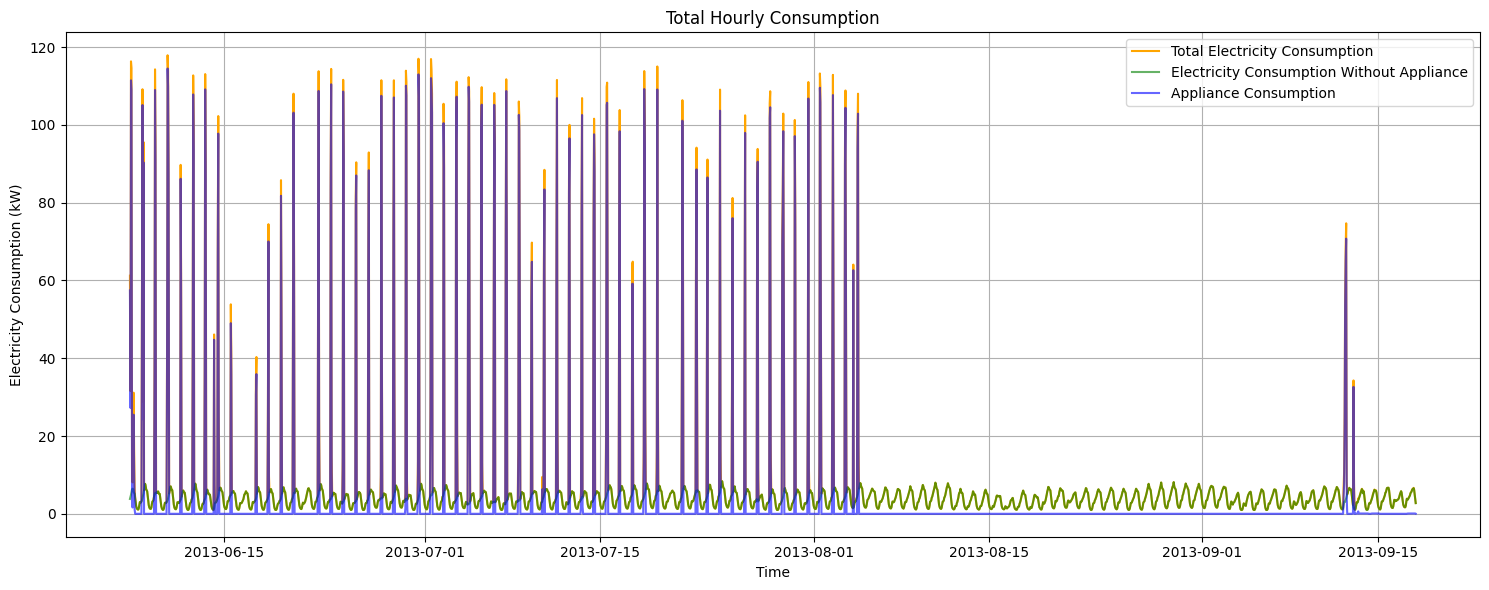

In [8]:

plt.figure(figsize=(15, 6))

# plot final_data
plt.plot(final_data['time'], final_data['Total_Consumption'], label='Total Electricity Consumption', color='orange')

plt.plot(final_data['time'], final_data['Total_Consumption_Before_Merge'], label='Electricity Consumption Without Appliance', color='green', alpha=0.6)

plt.plot(final_data['time'], final_data['New_App_Electricity'], label='Appliance Consumption', color='blue', alpha=0.6)

plt.title('Total Hourly Consumption')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()

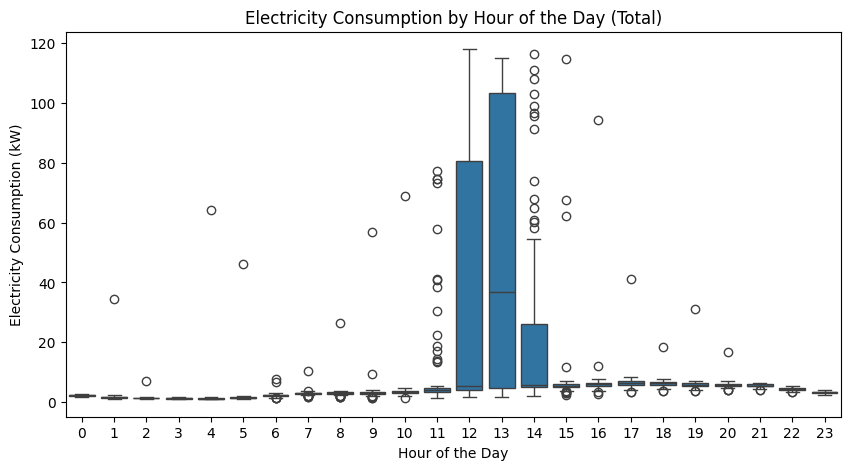

In [9]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='hour', y='Total_Consumption', data=final_data)
plt.title('Electricity Consumption by Hour of the Day (Total)')
plt.xlabel('Hour of the Day')
plt.ylabel('Electricity Consumption (kW)')
plt.show()

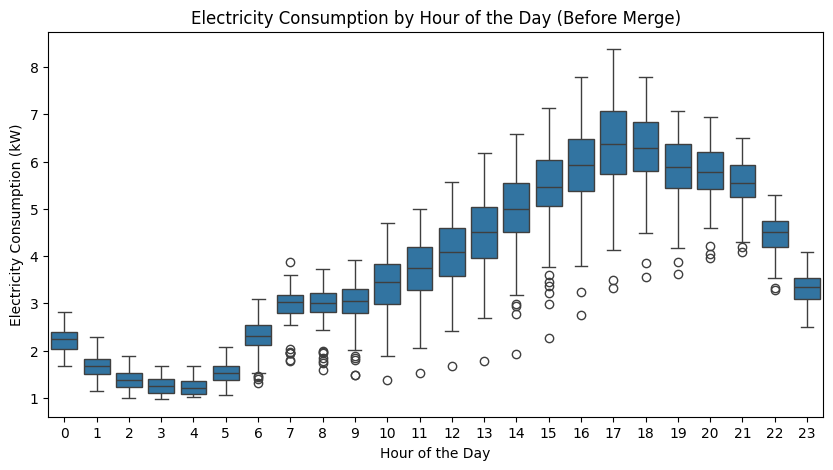

In [10]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='hour', y='Total_Consumption_Before_Merge', data=final_data)
plt.title('Electricity Consumption by Hour of the Day (Before Merge)')
plt.xlabel('Hour of the Day')
plt.ylabel('Electricity Consumption (kW)')
plt.show()

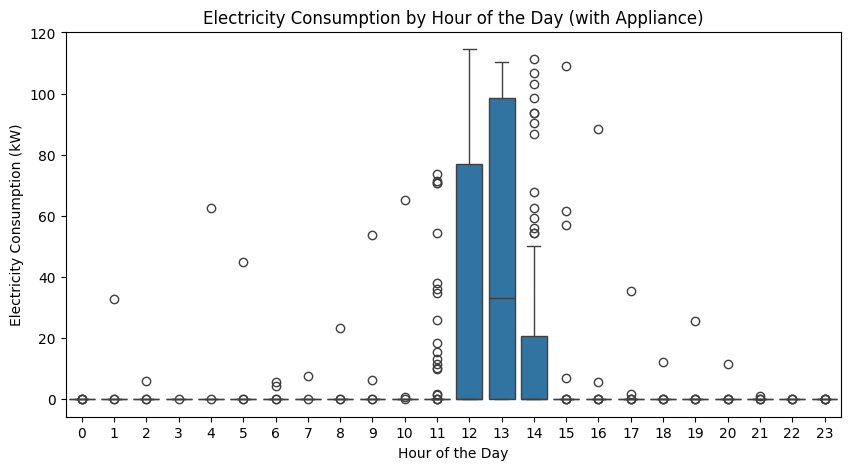

In [11]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='hour', y='New_App_Electricity', data=final_data)
plt.title('Electricity Consumption by Hour of the Day (with Appliance)')
plt.xlabel('Hour of the Day')
plt.ylabel('Electricity Consumption (kW)')
plt.show()

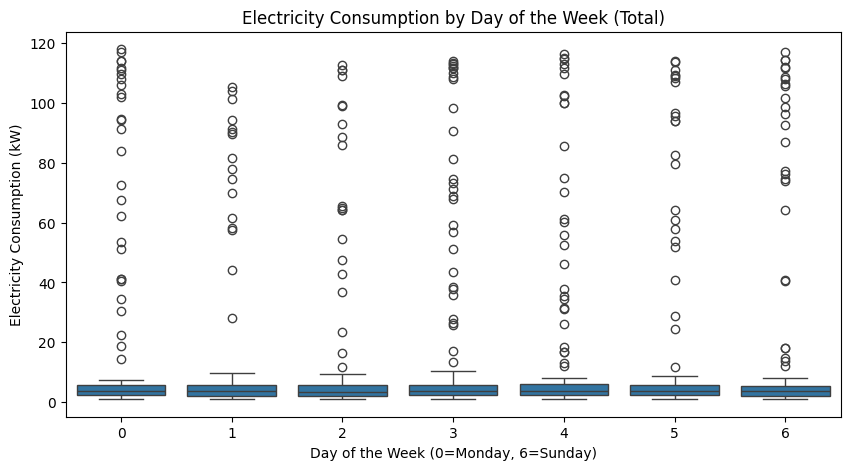

In [12]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday', y='Total_Consumption', data=final_data)
plt.title('Electricity Consumption by Day of the Week (Total)')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Electricity Consumption (kW)')
plt.show()

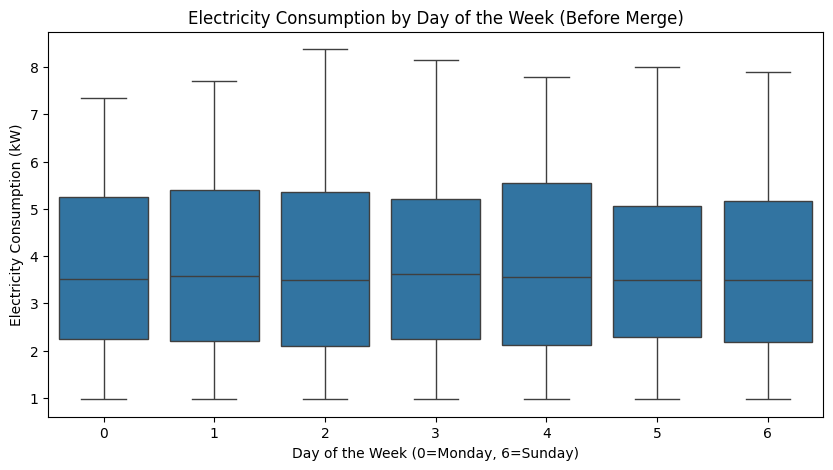

In [13]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday', y='Total_Consumption_Before_Merge', data=final_data)
plt.title('Electricity Consumption by Day of the Week (Before Merge)')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Electricity Consumption (kW)')
plt.show()

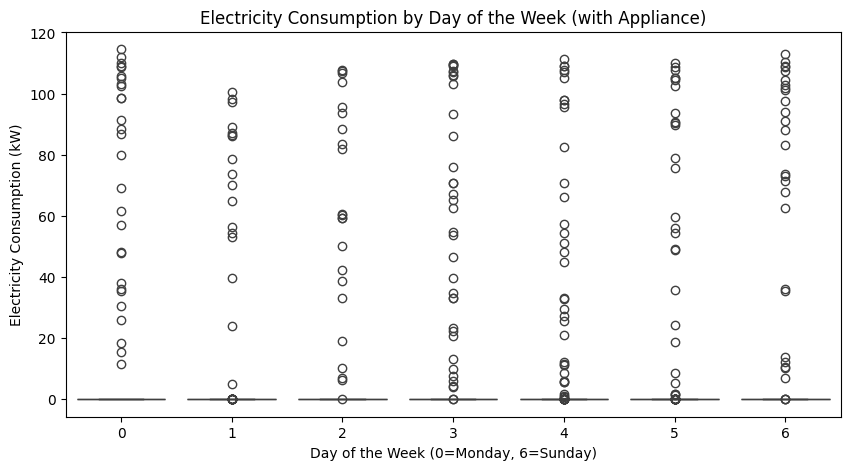

In [14]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday', y='New_App_Electricity', data=final_data)
plt.title('Electricity Consumption by Day of the Week (with Appliance)')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Electricity Consumption (kW)')
plt.show()

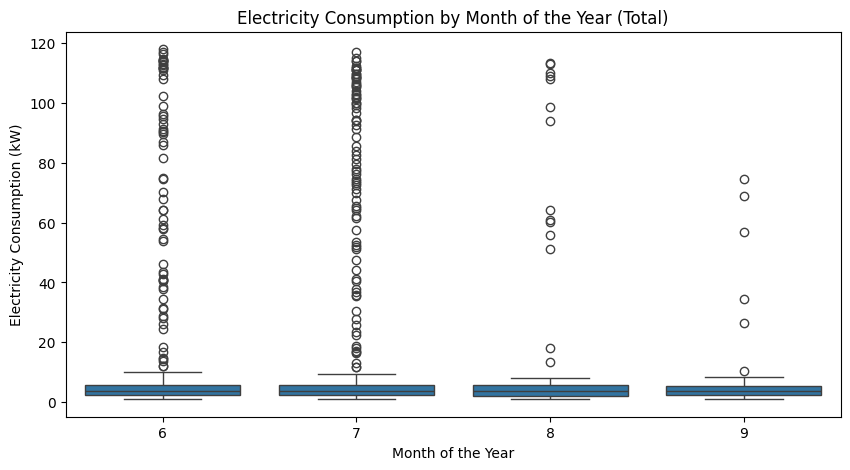

In [15]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='month', y='Total_Consumption', data=final_data)
plt.title('Electricity Consumption by Month of the Year (Total)')
plt.xlabel('Month of the Year')
plt.ylabel('Electricity Consumption (kW)')
plt.show()

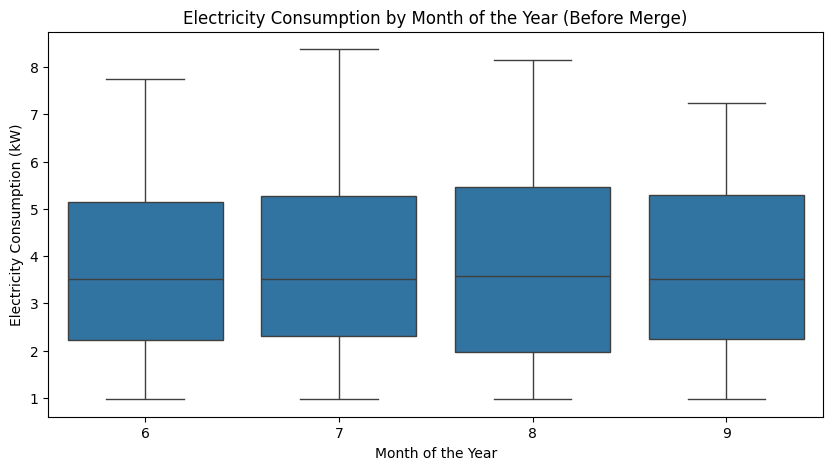

In [16]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='month', y='Total_Consumption_Before_Merge', data=final_data)
plt.title('Electricity Consumption by Month of the Year (Before Merge)')
plt.xlabel('Month of the Year')
plt.ylabel('Electricity Consumption (kW)')
plt.show()

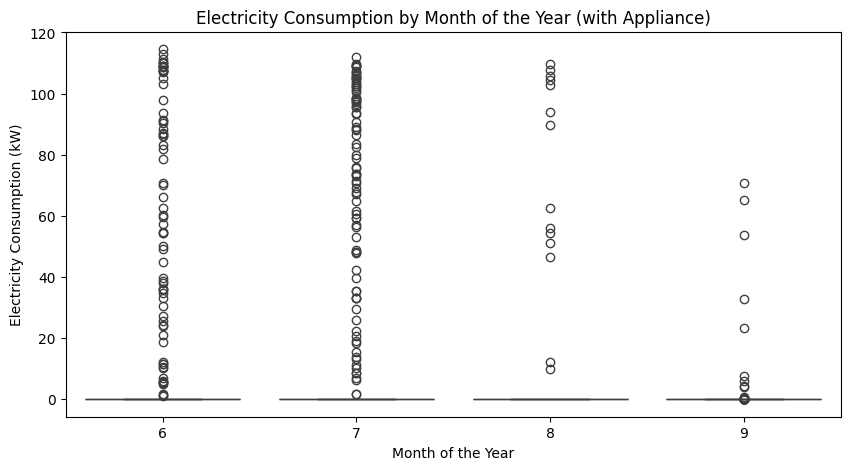

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='month', y='New_App_Electricity', data=final_data)
plt.title('Electricity Consumption by Month of the Year (with Appliance)')
plt.xlabel('Month of the Year')
plt.ylabel('Electricity Consumption (kW)')
plt.show()